In [21]:
import re
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [22]:
# загружаем исходные данные
data = pd.read_excel('./data/weather.xlsx', engine="openpyxl")
data.head()

,дата,показатель
0,2023-03-01,тепло
1,2023-03-01,высокая влажность воздуха
2,2023-03-01,низкое давление
3,2023-03-01,дождь
4,2023-03-02,мороз


In [23]:
# проверяем данные на наличие пропусков
is_nan = data.isna().sum()
is_nan

дата          0
показатель    0
dtype: int64

In [24]:
# посмотрим на группы товаров
Frequency_of_items = data.groupby(pd.Grouper(key='показатель')).size().reset_index(name='count')
fig = px.treemap(Frequency_of_items, path=['показатель'], values='count')
fig.update_layout(title_text='Показатели',
                  title_x=0.5, title_font=dict(size=18))
fig.update_traces(textinfo="label+value")
fig.show()

In [25]:
# группируем показатели по датам
data['показатель'] = data['показатель'].transform(lambda x: [x])
data = data.groupby(['дата']).sum()['показатель'].reset_index(drop=True)
data.head()

0    [тепло, высокая влажность воздуха, низкое давл...
1                                        [мороз, снег]
2                                [мороз, снег, метель]
3                                              [мороз]
4                                      [мороз, метель]
Name: показатель, dtype: object

In [26]:
# приводим данные к формату, который принимает функция apriori
# показатели в данном случае это наши категориальные признаки
# каждая строка это транзакция
encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(data).transform(data), columns=encoder.columns_)
transactions.head()

,высокая влажность воздуха,высокое давление,гроза,дождь,жара,метель,мороз,низкое давление,снег,тепло
0,True,False,False,True,False,False,False,True,False,True
1,False,False,False,False,False,False,True,False,True,False
2,False,False,False,False,False,True,True,False,True,False
3,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,True,True,False,False,False


In [27]:
# frequent_itemsets - частые наборы данных
# rules - наборы данных
# min_support - минимальная поддержка. Подмножество не является частным если:
### P(I) < min_support, где I — любой непустой набор элементов
### Любое подмножество в наборе элементов имеет значение меньше минимальной поддержки
frequent_itemsets = apriori(transactions, min_support=0.025, use_colnames=True, max_len=2).sort_values(by="support")
print('Frequent itemsets:')
display(frequent_itemsets.head(10))
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5).sort_values('lift', ascending=False)
print('Rules:')
print('antecedents - посылка')
print('consequents - следствие')
display(rules.head(10))
print("Rules identified: ", len(rules))

Frequent itemsets:


,support,itemsets
29,0.032258,"(тепло, снег)"
26,0.032258,"(мороз, низкое давление)"
24,0.032258,"(метель, низкое давление)"
20,0.032258,"(дождь, низкое давление)"
19,0.032258,"(мороз, дождь)"
28,0.032258,"(тепло, низкое давление)"
17,0.064516,"(гроза, жара)"
15,0.064516,"(дождь, высокое давление)"
10,0.064516,"(гроза, высокая влажность воздуха)"
12,0.064516,"(высокая влажность воздуха, жара)"


Rules:
antecedents - посылка
consequents - следствие


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(гроза),(жара),0.096774,0.096774,0.064516,0.666667,6.888889,0.055151,2.709677
1,(жара),(гроза),0.096774,0.096774,0.064516,0.666667,6.888889,0.055151,2.709677
11,(низкое давление),(гроза),0.193548,0.096774,0.096774,0.500000,5.166667,0.078044,1.806452
8,(жара),(низкое давление),0.096774,0.193548,0.096774,1.000000,5.166667,0.078044,inf
9,(низкое давление),(жара),0.193548,0.096774,0.096774,0.500000,5.166667,0.078044,1.806452
10,(гроза),(низкое давление),0.096774,0.193548,0.096774,1.000000,5.166667,0.078044,inf
4,(гроза),(высокая влажность воздуха),0.096774,0.225806,0.064516,0.666667,2.952381,0.042664,2.322581
5,(высокая влажность воздуха),(гроза),0.225806,0.096774,0.064516,0.285714,2.952381,0.042664,1.264516
6,(высокая влажность воздуха),(жара),0.225806,0.096774,0.064516,0.285714,2.952381,0.042664,1.264516
7,(жара),(высокая влажность воздуха),0.096774,0.225806,0.064516,0.666667,2.952381,0.042664,2.322581


Rules identified:  24


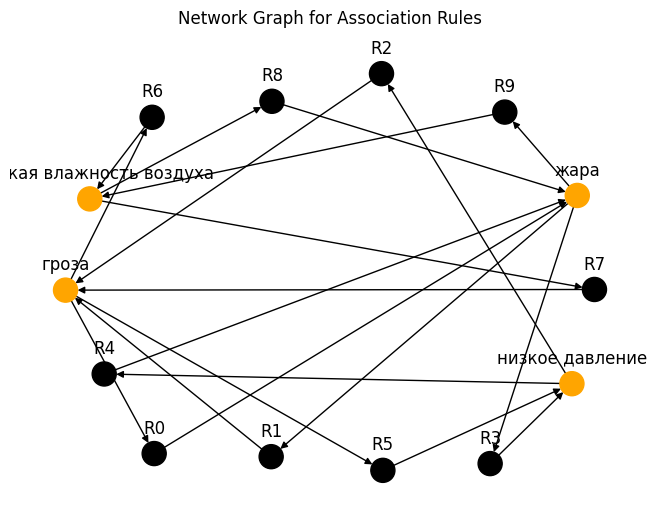

In [28]:
# визуализируем связь между продуктами в виде графа
def draw_graph(rules, rules_count):
    network = nx.DiGraph()

    for i in range(rules_count):
        # добавление узла правила
        network.add_nodes_from(['R' + str(i)])
        for antecedents in rules.iloc[i]['antecedents']:
            # Добавление узла-предшественника и ссылки на правило
            network.add_nodes_from([antecedents])
            network.add_edge(antecedents, 'R' + str(i),  weight=2)
            for consequents in rules.iloc[i]['consequents']:
                # Добавление узла-последователя и ссылки на правило
                network.add_nodes_from([consequents])
                network.add_edge('R' + str(i), consequents,  weight = 2)

    color_map=[]  
  
    # Для каждого узла, если это правило, цвет черный, в противном случае - оранжевый.
    for node in network:
        if re.compile(r'^[R]\d+$').fullmatch(node) != None:
            color_map.append('black')
        else:
            color_map.append('orange')
  
    # Расположение узлов с помощью spring layout
    pos = nx.spring_layout(network, k=16, scale=1)
    # Построение сетевого графа
    nx.draw(network, pos, node_color = color_map, font_size=8)            
  
    # Сдвиг расположения текста вверх
    for p in pos:  
        pos[p][1] += 0.12

    nx.draw_networkx_labels(network, pos)
    plt.title('Network Graph for Association Rules')
    plt.show()

draw_graph(rules, 10)

Дождь:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(высокое давление),(дождь),0.096774,0.290323,0.064516,0.666667,2.296296,0.036420,2.129032
1,(тепло),(дождь),0.387097,0.290323,0.193548,0.500000,1.722222,0.081165,1.419355


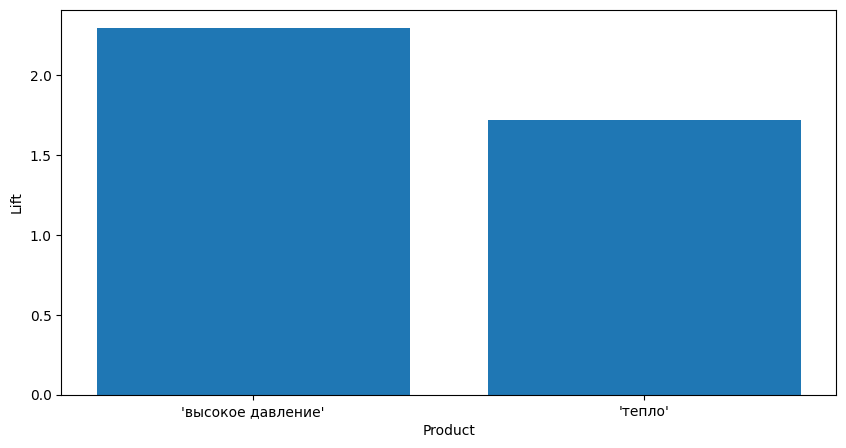

Гроза:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(жара),(гроза),0.096774,0.096774,0.064516,0.666667,6.888889,0.055151,2.709677
1,(низкое давление),(гроза),0.193548,0.096774,0.096774,0.500000,5.166667,0.078044,1.806452
2,(высокая влажность воздуха),(гроза),0.225806,0.096774,0.064516,0.285714,2.952381,0.042664,1.264516


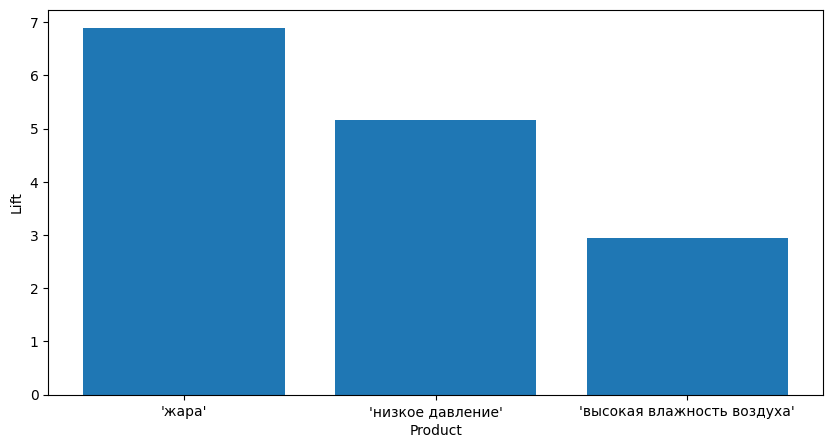

Метель:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(снег),(метель),0.225806,0.225806,0.129032,0.571429,2.530612,0.078044,1.806452
1,(мороз),(метель),0.322581,0.225806,0.161290,0.500000,2.214286,0.088450,1.548387


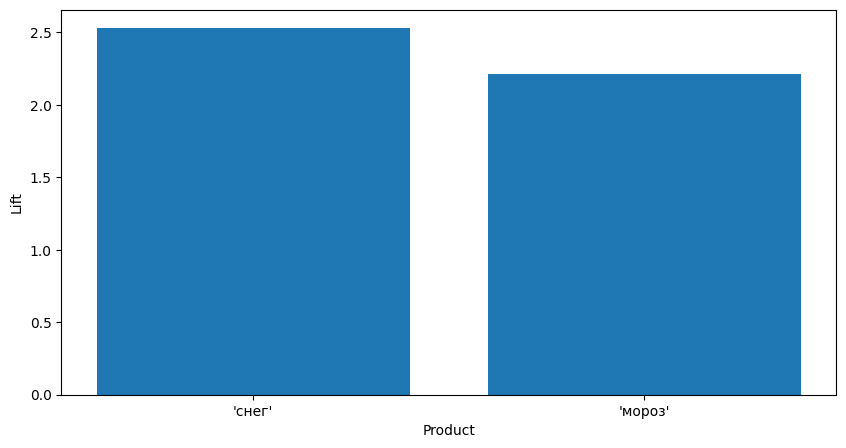

In [29]:
# посмотрим какие продукты стимулируют продажи других продуктов
rain_rules = rules[rules['consequents'].astype(str).str.contains('дождь')]
rain_rules = rain_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

storm_rules = rules[rules['consequents'].astype(str).str.contains('гроза')]
storm_rules = storm_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

blizzard_rules = rules[rules['consequents'].astype(str).str.contains('метель')]
blizzard_rules = blizzard_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

print('Дождь:')
display(rain_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in rain_rules.head()['antecedents']]
count = np.array(rain_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()

print('Гроза:')
display(storm_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in storm_rules.head()['antecedents']]
count = np.array(storm_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()

print('Метель:')
display(blizzard_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in blizzard_rules.head()['antecedents']]
count = np.array(blizzard_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()
